In [1]:
import os
import time

import numpy as np
import pandas 
import geopandas

from shapely.ops import unary_union
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import re
from pprint import pprint

thisyear = 2018

script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
data_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/districts_with_data/'
output_dir = data_dir

acs5_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/{0:.0f}/estimates/'.format(thisyear)
shapefiledir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/{0:.0f}/'.format(thisyear)
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

water_area_tol = 1 * 1000 * 1000
overlap_area_tract_tol = 22000
overlap_area_bg_tol = 4000
#smallest tract in US is Cook County, Illinois Tract 307.02 (area = 22,094 m^2)
#smallest block group in US is Miami-Dade County, FL, Census Tract 2703, block group 7 (area = 4,436 m^2)
equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163

scale = 1
map_buffer = 0.25 # extra room on each edge of the maps, in degres

#plt.rc('axes', prop_cycle=default_cycler)

district_color_cycle = ['red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime']
#color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#color_cycle = color_cycle + color_cycle
#color_cycle = color_cycle + color_cycle

debug = 1
g = 0

print('ok')

ok


# Get congressional district shapefiles

WITH data on metro and city areas as a percentage of total district area.

This assumes that you have already run <code>districts-cities.ipynb</code>.

In [2]:
s = time.time()
print('reading congressional districts with urban/rural area data...')
cd_gdf = geopandas.read_file(data_dir+'cd116_with_areas_and_types_435.shp')

print('Fixing at-large districts by setting district number to 1...')
cd_gdf.loc[cd_gdf['CD116FP'] == 0, 'CD116FP'] = 1  # At-large districts will be called District 1

cd_gdf = cd_gdf.rename(columns = {'pct_metro_': 'pct_metro_area', 'pct_city_a': 'pct_city_area'})
cd_gdf.loc[:, 'CD116FP'] = cd_gdf['CD116FP'].apply(lambda x: int(x))
cd_gdf = cd_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} districts in {1:,.1f} seconds.'.format(len(cd_gdf), e-s))
#sorted(cd_gdf[cd_gdf['CD116FP'] == 0]['STUSAB'].tolist())


reading congressional districts with urban/rural area data...
Fixing at-large districts by setting district number to 1...
Read 435 districts in 2.0 seconds.


# Load block groups (nationwide)

In [3]:
s = time.time()
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()

for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)

print('converting block group identifiers and coords to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: x[0:4]+'.'+x[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')
bg_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(bg_gdf['INTPTLAT'], errors='coerce')
bg_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(bg_gdf['INTPTLON'], errors='coerce')

#bg_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_gdf['NAME'], errors='coerce')
# bg_gdf = tract_gdf.sort_values(by='NAME')

print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))
bg_gdf = bg_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
if (debug >= 1):
    print('Read {0:,.0f} census block groups in {1:,.1f} seconds!'.format(len(bg_gdf), e-s))

#bg_gdf.sample(1).T


	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
converting block group identifiers and coords to numeric...
assigning GEOID as index...
Read 217,739 census block groups in 134.6 seconds!


## Look up state and county names from numbers

In [4]:
s = time.time()

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
state_codes_df = state_codes_df.rename(columns={'STATE': 'STATEFP'})
bg_gdf = bg_gdf.reset_index().merge(state_codes_df, how='left', on='STATEFP').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATEFP', 'County Code (FIPS)': 'COUNTYFP', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
bg_gdf = bg_gdf.reset_index().merge(county_names_df[['STATEFP', 'COUNTYFP', 'COUNTY_NAME']], how='left', on=['STATEFP', 'COUNTYFP']).set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Added state and county names in {0:,.1f} seconds!'.format(e-s))


looking up state names from numbers...
looking up county names from numbers...
Added state and county names in 13.4 seconds!


## Get population data, and join onto shapefiles

In [5]:
s = time.time()
print('reading ACS5 census data for {0:.0f}...'.format(thisyear))
acs5_estimates_df = pandas.read_csv(acs5_dir+'estimates_acs{0:}_tract_bg_gerrymandering.csv'.format(thisyear), index_col='GEOID')

print('joining population data onto block group shapefiles...')
bg_gdf = bg_gdf.join(acs5_estimates_df[['B01001_001', 'Geography Name']], how='left')
bg_gdf = bg_gdf.rename(columns={'B01001_001': 'total_population'})

e = time.time()
g = g + (e-s)
print('\nadded ACS5 census data to {0:,.0f} block groups in {1:,.0f} seconds!'.format(len(bg_gdf), e-s))


reading ACS5 census data for 2018...
joining population data onto block group shapefiles...

added ACS5 census data to 217,739 block groups in 4 seconds!


# Geo-match congressional districts

If a tract overlaps with only one district, match that tract to its district.
If it overlaps multiple districts, divide into block groups and match each block group to its matching districts.

## Get what has been matched so far

In [6]:
s = time.time()
print('reading districts that have been matched so far...')
assembler_df = pandas.read_csv(data_dir+'block_group_with_district_1_7.csv', encoding='utf-8', index_col='GEOID')
assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
assembler_gdf.crs = bg_gdf.crs


cd_gdf = cd_gdf[~cd_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]
bg_gdf = bg_gdf[~bg_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]

print('backing up...')
cd_gdf_bk = cd_gdf
bg_gdf_bk = bg_gdf
assembler_gdf_bk = assembler_gdf

e = time.time()
g = g + (e-s)
print('Kept {0:,.0f} block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))




reading districts that have been matched so far...
backing up...
Kept 170,731 block groups in 0.9 seconds!


## States with 8 districts

These are harder, because first we have to know which block groups overlap multiple districts.

Create a function to mark those.

### Create function to mark block groups with the districts they overlap

In [7]:
def mark_block_groups_with_districts_bitmask_values(block_group_info_gdf, congressional_district_info_gdf, debug=0):    
    working_with_state = block_group_info_gdf['STATE_NAME'].head(1).values[0]
    
    marked_s = pandas.Series()
    
    equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
    cnt = 0
    if (debug > 0):    
        print('\tAssigning bitmask values to block groups in {0:}...'.format(working_with_state))
    
    for ix, thisrow in block_group_info_gdf.iterrows():    
        bitmasker = 0
        if (debug > 1):
            print(ix)
            print('\t\tMatching {0:}, {1:} census tract {2:}, block group {3:}...'.format(thisrow['STATE_NAME'], thisrow['COUNTY_NAME'], thisrow['TRACTCE'], thisrow['BLKGRPCE']))
            print('\n')
        if ((np.mod(cnt,100) == 0) | (cnt == len(block_group_info_gdf) - 1)):
            if (debug > 1):
                print('\t\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
            else:
                print('\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
                
        for jx, thatrow in congressional_district_info_gdf.iterrows():
            if (thisrow.geometry.intersects(thatrow.geometry)):
                this_district_overlap_area = block_group_info_gdf[block_group_info_gdf.index == ix].to_crs(equal_area_crs).geometry.values[0].intersection(congressional_district_info_gdf[congressional_district_info_gdf.index == jx].to_crs(equal_area_crs).geometry.values[0]).area
                if (this_district_overlap_area >= overlap_area_bg_tol):
                    bitmasker = bitmasker + 2**(thatrow['CD116FP']-1)
                    if (debug > 1):
                        print('\t\t\t\tIntersects District {0:.0f} with overlap area {1:,.1f} km^2...'.format(thatrow['CD116FP'], this_district_overlap_area/1000000))               
        marked_s.loc[ix] = bitmasker
        cnt = cnt + 1
        
    return marked_s
print('defined district-marking function!')


defined district-marking function!


## Find block group / district overlaps, assign districts to non-overlapping block groups

Uses function defined above

In [8]:
s = time.time()

print('getting from backup...')
bg_gdf = bg_gdf_bk
assembler_gdf = assembler_gdf_bk

e = time.time()
g = g + (e-s)

for this_state in ['MD']: #['MN', 'MO', 'WI']:
    s = time.time()
    state_full_name = bg_gdf[bg_gdf['STUSAB'] == this_state]['STATE_NAME'].values[0]
    print('\n')
    print('Processing {0:}...'.format(state_full_name))
    assembler_i_gdf = bg_gdf[bg_gdf['STUSAB'] == this_state]

    district_bitmask_values_s = mark_block_groups_with_districts_bitmask_values(
        bg_gdf[bg_gdf['STUSAB'] == this_state][['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population', 'geometry']], 
        cd_gdf[cd_gdf['STUSAB'] == this_state][['STUSAB', 'CD116FP', 'geometry']], 
        debug
    )
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask_values = district_bitmask_values_s)
    
    
    if (debug > 0):
        print('\tconverting bitmask values to human-readable bitmasks...')        
    nDistrictsForBitmaskeration = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116FP'].max()
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask = 
                                             assembler_i_gdf['congressional_districts_bitmask_values'].apply(lambda x: 'x'+np.binary_repr(int(x)).zfill(nDistrictsForBitmaskeration)[::-1])
                                            )

    if (debug > 0):
        print('\tcounting number of districts each block group overlaps...')        
    
    assembler_i_gdf = assembler_i_gdf.assign(nDistricts = 
                                             assembler_i_gdf['congressional_districts_bitmask'].apply(lambda x: x[1:].count("1"))
                                            )
    if (debug > 0):
        print('\tassigning congressional district to each block group with only one overlap...')
        
    assembler_i_gdf = assembler_i_gdf.assign(block_based_district = np.nan)
    assembler_i_gdf.loc[
        assembler_i_gdf['nDistricts'] == 1, 
        'block_based_district'] = assembler_i_gdf[
                        assembler_i_gdf['nDistricts'] == 1
                    ]['congressional_districts_bitmask'].apply(lambda x: x.find("1"))
    
    print('\t...-1 otherwise...')
    assembler_i_gdf.loc[assembler_i_gdf['nDistricts'] > 1, 'block_based_district'] = -1
    
    if (debug > 0):
        print('\tjoining {0:} to the rest of the assembler dataframe...'.format(state_full_name))
    assembler_gdf = pandas.concat((assembler_gdf, assembler_i_gdf), axis=0, sort=False)
    if (debug > 0):
        print("\n")
    e = time.time()
    g = g + (e-s)

    print('matched districts for {0:,.0f} block groups in {1:} in {2:,.0f} minutes {3:,.0f} seconds!'.format(len(assembler_i_gdf), this_state, np.floor((e-s)/60), np.floor((e-s)%60)))

print('backing up...')
assembler_gdf_justparsed = assembler_gdf

print('GRAND TOTAL TIME: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))

# print(assembler_gdf.groupby('STUSAB').size())
# print(assembler_gdf.groupby(['STUSAB', 'nDistricts']).size())
#print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# assembler_gdf.sample(2).T

#assembler_gdf[assembler_gdf['STUSAB'] == this_state].groupby('congressional_districts_bitmask').size()


getting from backup...


Processing Maryland...
	Assigning bitmask values to block groups in Maryland...
		processing row 1 of 3,926...
		processing row 101 of 3,926...
		processing row 201 of 3,926...
		processing row 301 of 3,926...
		processing row 401 of 3,926...
		processing row 501 of 3,926...
		processing row 601 of 3,926...
		processing row 701 of 3,926...
		processing row 801 of 3,926...
		processing row 901 of 3,926...
		processing row 1,001 of 3,926...
		processing row 1,101 of 3,926...
		processing row 1,201 of 3,926...
		processing row 1,301 of 3,926...
		processing row 1,401 of 3,926...
		processing row 1,501 of 3,926...
		processing row 1,601 of 3,926...
		processing row 1,701 of 3,926...
		processing row 1,801 of 3,926...
		processing row 1,901 of 3,926...
		processing row 2,001 of 3,926...
		processing row 2,101 of 3,926...
		processing row 2,201 of 3,926...
		processing row 2,301 of 3,926...
		processing row 2,401 of 3,926...
		processing row 2,501 of 3,926...
		proce

# WRITE OUTPUT

In [ ]:
# z = pandas.read_csv(output_dir+'block_group_with_district_1_8.csv', encoding='utf-8', index_col='GEOID')


# #z.head(1).T
# z.shape

In [ ]:
## Test that output wrote correctly

In [ ]:
# s = time.time()
# z = pandas.read_csv(output_dir+'block_group_with_district_1_6.csv', index_col='GEOID')
# bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
# bg_gdf = geopandas.GeoDataFrame()
# for i in range(0, len(bg_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
#     bg_gdf_i = geopandas.read_file(bg_file_list[i])
#     bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)
# e = time.time()
# print('done in {0:,.1f} seconds'.format(e-s))


# s = time.time()
# print('converting block group identifiers to numeric...')
# bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
# bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
# bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: str(x)[0:4]+'.'+str(x)[4:]), errors='coerce')
# bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')


# print('assigning GEOID as index...')
# bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))#
# bg_gdf = bg_gdf.set_index('GEOID')

# geopandas.GeoDataFrame(data=z.join(bg_gdf.geometry, how='left'), crs=bg_gdf.crs, geometry='geometry').plot()

# e = time.time()
# print('done in {0:,.1f} seconds'.format(e-s))


## MARYLAND

In [36]:
s = time.time()
print('Assigning districts based on examination to block groups that overlap multiple districts...')


#### MARYLAND
assembler_gdf.loc[['15000US240037406031'], 'block_based_district'] = 2  # was 2,3,4,5
assembler_gdf.loc[['15000US240037407022'], 'block_based_district'] = 4  # was 3,4,5
assembler_gdf.loc[['15000US240054085023', '15000US240054901001'], 'block_based_district'] = 2 
assembler_gdf.loc[['15000US240054901003', '15000US240253022002', '15000US240253024003', '15000US240054113034', '15000US240054113021', '15000US240054111022', '15000US240253012052'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US240253064006', '15000US240253028011', '15000US240253028012', '15000US240253028013', '15000US240253028021', '15000US240253028023', '15000US240253028024', '15000US240253064001', '15000US240054113033' ,'15000US240054114041', '15000US240253017031'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US240253011071', '15000US240253011072', '15000US240253012051', '15000US240253014011', '15000US240253014013', '15000US240253013013', '15000US240253013021', '15000US240253013023', '15000US240253013024', '15000US240253013011'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US240054070022', '15000US240054070023'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US240054089002', '15000US240054101004', '15000US240054102003', '15000US240054112021', '15000US240054112023'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US240054112022'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US240135061011'], 'block_based_district'] = 1

assembler_gdf.loc[['15000US240054049003', '15000US240054113062', '15000US240054114082', '15000US245102704021'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US240054042021', '15000US240054042024', '15000US240054114071', '15000US240054114072', '15000US240054114083', '15000US240054404001', '15000US245102705023'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US240054405001', '15000US240054406001', '15000US240054408001'], 'block_based_district'] = 3

assembler_gdf.loc[['15000US245102605013'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US245102401001', '15000US245100101003', '15000US245102101001', '15000US245102303001', '15000US245102605011', '15000US245102401002', '15000US245100203003', '15000US245100203002', '15000US245102402001', '15000US245102404002', '15000US245100104002'], 'block_based_district'] = 3

# # print("backing up again...")
# # assembler_gdf_bk2 = assembler_gdf

e = time.time()
g = g + (e-s)

#print('Grand total time: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))

#print(assembler_gdf.groupby('congressional_districts_bitmask').size())
print(assembler_gdf[assembler_gdf['STUSAB'] == 'MD'].groupby(['STUSAB', 'block_based_district']).size())



Assigning districts based on examination to block groups that overlap multiple districts...
STUSAB  block_based_district
MD      -1.0                    216
         1.0                    505
         2.0                    454
         3.0                    445
         4.0                    413
         5.0                    380
         6.0                    438
         7.0                    589
         8.0                    486
dtype: int64


In [37]:
assembler_gdf[
    (assembler_gdf['STUSAB'] == 'MD')
    & (assembler_gdf['block_based_district'] == -1)
].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)

# 2 and 3 (x01100000)    44
# 2 and 7 (x01000010)    18
# 3 and 4 (x00110000)    18
# 3 and 5 (x00101000)     1
# 3 and 7 (x00100010)    53
# 3 and 8 (x00100001)    18
# 4 and 5 (x00011000)    36
# 6 and 8 (x00000101)    43

congressional_districts_bitmask
x01100000    29
x01000010    18
x00110000    18
x00101000     1
x00100010    53
x00100001    18
x00011000    36
x00000101    43
dtype: int64

Plotting official districts...
plotting tracts that overlap multiple districts...
labeling block groups...
plotting water...
plotting places...
plotting roads...


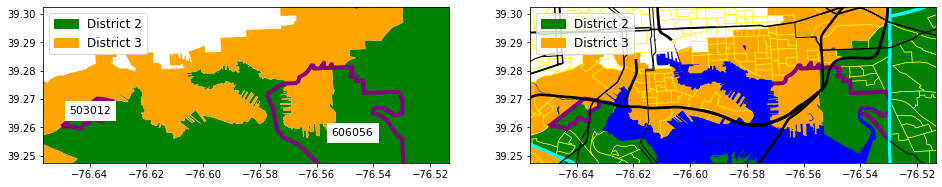

15000US245102503012
15000US245102606056
Done in 0 minutes 26 seconds!


In [38]:
s = time.time()

this_state = 'MD'
test_this_bitmask = 'x01100000'

manual_plot_limits = True
show_small_roads = False

manual_xlim = (-76.65, -76.52)
manual_ylim = (39.25, 39.3)


legend_location = 'upper left'

buffer_percent = 0.05

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))


print('Plotting official districts...')
for ax in (ax1, ax2):
    legend_list = []
    for i in range(1, len(test_this_bitmask)):
        if (test_this_bitmask[i] == '1'):
            cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
            legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax, color='none', edgecolor='yellow', lw=0.5)

print('plotting tracts that overlap multiple districts...')
for ax in (ax1,ax2):
    assembler_gdf[
        (assembler_gdf['block_based_district'] == -1)
        & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
    ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

    if (manual_plot_limits):
        xlimits = (manual_xlim[0], manual_xlim[1])
        ylimits = (manual_ylim[0], manual_ylim[1])
    else:
        bounding_box = unary_union(
            assembler_gdf[
                (assembler_gdf['block_based_district'] == -1)
                & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
            ].geometry.tolist()
        ).bounds
        xlimits = (bounding_box[0], bounding_box[2])
        ylimits = (bounding_box[1], bounding_box[3])

    xspan = xlimits[1] - xlimits[0]
    yspan = ylimits[1] - ylimits[0]
    xbuffer = xspan * buffer_percent
    ybuffer = yspan * buffer_percent
    ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
    ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
    ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
    
print('labeling block groups...')
#####  add labels for block groups with overlap
b = []
for ix, thisrow in assembler_gdf[
    (assembler_gdf['STUSAB'] == this_state) 
    & (assembler_gdf['block_based_district'] == -1) 
    & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
    & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
    & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
].iterrows():
    b.append(ix)
    annotator = ix[-6:]
    ax1.annotate(annotator, 
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                 color='black', backgroundcolor='white', fontsize=11, ha='center'
               )
    
print('plotting water...')
water_gdf.plot(ax=ax2, color='blue')


print('plotting places...')
place_gdf.plot(ax=ax2, color='none', edgecolor='cyan', linewidth=3)#color='white', alpha=0.5)

for ix, thisrow in place_gdf[
    ((place_gdf['INTPTLON'] >= xlimits[0]) & (place_gdf['INTPTLON'] <= xlimits[1]))
    & ((place_gdf['INTPTLAT'] >= ylimits[0]) & (place_gdf['INTPTLAT'] <= ylimits[1]))
    #& (place_gdf['NAME'].isin(['Baltimore', 'Rosedale']))
].iterrows():
    b.append(ix)
    annotator = thisrow['NAME'].upper()
    ax2.annotate(annotator, 
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                 color='cyan', backgroundcolor='white', fontsize=10, ha='center'
               )


print('plotting roads...')
if (show_small_roads):
    roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

plt.show()

b = sorted(b)
for i in range(0,len(b)):
    print(b[i])
    
explore_more = b

e = time.time()
g = g + (e-s)
print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


### Further investigation

In [39]:
s = time.time()
label_small_roads = False
label_small_road_types = [] 
show_places = True
show_water = False
basesize = 10
aspect_ratio = xspan / yspan

i = 0
this_block_group_id = explore_more[i]

suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0 }
other_roads = []

print('Examining block group {0:}'.format(this_block_group_id))
print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

block_group_geo = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.values[0]
total_block_group_area = block_group_geo.area
print('Total area {0:,.1f} km^2...'.format(total_block_group_area / 1000000))
print('\n')

print('Finding roads in this block group...')
road_linearids_in_this_block_group_list = []
cnt = 0
for ix, thisrow in roads_gdf.to_crs(equal_area_crs).iterrows():
    if ((np.mod(cnt, 50000) == 0) | (cnt == len(roads_gdf) - 1)):
        print('\tExamining road {0:,.0f} of {1:,.0f} in entire state...'.format(cnt+1, len(roads_gdf)))
    if (thisrow.geometry.intersects(block_group_geo)):
        road_linearids_in_this_block_group_list.append(ix)
    cnt = cnt + 1


print('Found {0:,.0f} roads in block group {1:}'.format(len(road_linearids_in_this_block_group_list), this_block_group_id))
print('\n')

for i in range(1, len(test_this_bitmask)):
    if (test_this_bitmask[i] == '1'):
        print('Matching BG {0:} with district {1:.0f}...'.format(this_block_group_id, i))
        this_district_overlap_geo = cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].to_crs(equal_area_crs).geometry.apply(lambda x: x.intersection(block_group_geo)).values[0]
        this_district_overlap_area = this_district_overlap_geo.area
        print('\tDistrict {0:} overlaps {1:.1%} of the area...'.format(i, this_district_overlap_area / total_block_group_area))        
        match_road_network_length = 0
        for jx, thatrow in roads_gdf[
            (roads_gdf.index.isin(road_linearids_in_this_block_group_list))
        ].to_crs(equal_area_crs).iterrows():
            if (thatrow.geometry.intersects(this_district_overlap_geo)):
                match_road_network_length += thatrow.geometry.intersection(this_district_overlap_geo).length
#        road_network_density = ((match_road_network_length)**2) / this_district_overlap_area
        road_network_density = match_road_network_length / this_district_overlap_area
        print('\tDistrict {0:} overlap has {1:,.1f} km roads in {2:.1f} km^2 area (density {3:,.1f}/km)...'.format(i, match_road_network_length/1000, this_district_overlap_area/1000000, 1000*road_network_density))
        print('\n')

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))


print('Plotting official districts...')

legend_list = []
for i in range(1, len(test_this_bitmask)):
    if (test_this_bitmask[i] == '1'):
        cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
        legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
            
print('plotting tracts that overlap multiple districts...')
assembler_gdf[
    assembler_gdf.index == this_block_group_id
].plot(ax=ax, color='none', edgecolor='white', linewidth=10)

bounding_box = unary_union(
    assembler_gdf[
        assembler_gdf.index == this_block_group_id
    ].geometry.tolist()
).bounds
xlimits = (bounding_box[0], bounding_box[2])
ylimits = (bounding_box[1], bounding_box[3])

xspan = xlimits[1] - xlimits[0]
yspan = ylimits[1] - ylimits[0]

xbuffer = xspan * buffer_percent
ybuffer = yspan * buffer_percent

ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
#ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
    
if (show_water):
    print('plotting water...')
    water_gdf.plot(ax=ax, color='blue')

print('plotting roads...')
roads_gdf[
    (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (~roads_gdf['RTTYP'].isin(['I','U','S','C']))
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
].plot(ax=ax, color='black', linewidth=0.5) 
roads_gdf[
    (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'C')
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
].plot(ax=ax, color='black', linewidth=1)
roads_gdf[
    (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'U')
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
].plot(ax=ax, color='black', linewidth=3)
roads_gdf[
    (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'I')
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
].plot(ax=ax, color='black', linewidth=5)

print('labeling roads...')
unique_names = []
for ix, thisrow in roads_gdf[roads_gdf.index.isin(road_linearids_in_this_block_group_list)].iterrows():
    has_custom_bbox = False
    thefontdict = {}
    labelsize = 9
    annotator = ''
    if (thisrow['RTTYP'] == 'I'):
        labelsize = 20
        annotator = thisrow['RTTYP']
        has_custom_bbox = True
        thebbox=dict(boxstyle="darrow", fc='white', ec='blue')
    elif (thisrow['RTTYP'] == 'U'):
        labelsize = 16
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
        has_custom_bbox = True
        thebbox=dict(boxstyle="square", fc='white', ec='red')
    elif (thisrow['RTTYP'] == 'S'):
        labelsize = 14
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
        has_custom_bbox = True
        thebbox=dict(boxstyle="round,pad=0.5,rounding_size=1", fc='white', ec='orange')
    elif (thisrow['RTTYP'] == 'C'):
        labelsize = 10
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
        has_custom_bbox = True
        thebbox=dict(boxstyle="sawtooth,pad=1", fc='white')
    elif (label_small_roads):
        labelsize = 9
        if (thisrow['FULLNAME'] not in unique_names):
            unique_names.append(thisrow['FULLNAME'])
            if (re.search("\s",str(thisrow['FULLNAME'])) != None):
                road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1]
                is_other_road_type = True
                for k, v in suffixes_to_count_dict.items():
                    if (road_suffix == k):
                        suffixes_to_count_dict[k] = suffixes_to_count_dict[k] + 1
                        is_other_road_type = False
                if (is_other_road_type):
                    other_roads.append(thisrow['FULLNAME'])
                if ((road_suffix in label_small_road_types) | (is_other_road_type)):
                    annotator = thisrow['FULLNAME']
    if (has_custom_bbox):
        plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                     color='black', backgroundcolor='white', fontsize=labelsize, ha='center', va='center',
                     bbox = thebbox)
    else:
        plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                     color='black', backgroundcolor='white', fontsize=labelsize, ha='center', va='center')

plt.title("Block Group {0:}".format(this_block_group_id), fontsize=18)

if (label_small_roads):
    print("\tAnalysis of road names:")
    for k,v in suffixes_to_count_dict.items():
        print('\t\t{0:}: {1:,.0f}'.format(k,v))
    print('\tOther road names:')
    for x in other_roads:
        print('\t\t',x)
    print('\n')

if (show_places):
    print('finding places...')
    print('\tshowing place names...')
    for ix, thisrow in place_gdf.iterrows():
        if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
            print('\t\t',thisrow['NAME'])
    print('\tplotting places...')    
    place_gdf.plot(ax=ax, color='none', edgecolor='purple', lw=5)
    print('\tlabeling places...')
    for ix, thisrow in place_gdf[
         ( (place_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (place_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
         & ( (place_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (place_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
    ].iterrows():
        annotator = thisrow['NAME'].upper()
        plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                 color='black', backgroundcolor='white', fontsize=16, ha='center', va='center')


print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

plt.show()



e = time.time()
g = g + (e-s)
print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))



Examining block group 15000US245102503012
Population: 1,458
Total area 0.8 km^2...


Finding roads in this block group...
	Examining road 1 of 265,200 in entire state...
	Examining road 50,001 of 265,200 in entire state...
	Examining road 100,001 of 265,200 in entire state...
	Examining road 150,001 of 265,200 in entire state...
	Examining road 200,001 of 265,200 in entire state...
	Examining road 250,001 of 265,200 in entire state...
	Examining road 265,200 of 265,200 in entire state...
Found 83 roads in block group 15000US245102503012


Matching BG 15000US245102503012 with district 2...
	District 2 overlaps 75.8% of the area...
	District 2 overlap has 10.2 km roads in 0.6 km^2 area (density 17.8/km)...


Matching BG 15000US245102503012 with district 3...
	District 3 overlaps 24.2% of the area...
	District 3 overlap has 4.6 km roads in 0.2 km^2 area (density 25.1/km)...


Plotting official districts...
plotting tracts that overlap multiple districts...
plotting roads...


/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


labeling roads...
finding places...
	showing place names...
		 Baltimore
	plotting places...
	labeling places...
http://maps.google.com/maps?ll=39.265,-76.641&spn=0.018,0.011&t=m


Done in 3 minutes 16 seconds!


### Get water areas, places, roads

In [10]:
s = time.time()

this_state = 'MD'
this_state_number = 24
#this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

if (debug >= 1):
    print('reading water shapefiles in {0:}...'.format(this_state))

water_gdf = geopandas.GeoDataFrame()
water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

for i in range(0, len(water_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
    water_gdf_i = geopandas.read_file(water_file_list[i])
    #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
    water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

water_gdf = water_gdf.set_index('HYDROID')
e = time.time()
g = g + (e-s)

if (debug >= 1):
    #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
    print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
#print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
s = time.time()

if (debug >= 1):
    print('reading place shapefiles in {0:}...'.format(this_state))

place_gdf = geopandas.GeoDataFrame()
place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

for i in range(0, len(place_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
    place_gdf_i = geopandas.read_file(place_file_list[i])
    
    place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

place_gdf = place_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)

if (debug >= 1):
    #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
    print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
#place_gdf.head(1)

s = time.time()

if (debug >= 1):
    print('reading roads shapefiles in {0:}...'.format(this_state))

roads_gdf = geopandas.GeoDataFrame()
roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

for i in range(0, len(roads_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
    roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
    roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

roads_gdf = roads_gdf.set_index('LINEARID')

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

e = time.time()
g = g + (e-s)

if (debug >= 1):
    #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
    print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))



reading water shapefiles in MD...
	Reading file 1 of 24...
	Reading file 11 of 24...
	Reading file 21 of 24...
	Reading file 24 of 24...
Read 15,012 bodies of water in 4 seconds!
reading place shapefiles in MD...
	Reading file 1 of 1...
Read 518 places in 0.6 seconds!
reading roads shapefiles in MD...
	Reading file 1 of 24...
	Reading file 11 of 24...
	Reading file 21 of 24...
	Reading file 24 of 24...
Read 265,200 roads in 30.8 seconds!


In [ ]:
### Further investigation    


Examining block group 15000US240054408001
Population: 3,320
Total area 2.9 km^2...


Found 167 roads in block group 15000US240054408001


Matching BG 15000US240054408001 with district 2...
	District 2 overlaps 36.9% of the area...
	District 2 overlap has 17.6 km roads (density 284.3)...


Matching BG 15000US240054408001 with district 3...
	District 3 overlaps 63.1% of the area...
	District 3 overlap has 24.3 km roads (density 317.6)...


Plotting official districts...
plotting tracts that overlap multiple districts...
plotting roads...


/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


labeling roads...
	Analysis of road names:
		Rd: 10
		Dr: 9
		St: 0
		Ave: 9
		Blvd: 2
		Ln: 5
		Cir: 1
		Way: 2
		Ct: 23
	Other road names:
		 Baltimore Beltway
		 John F Kennedy Memorial Hwy
		 Leatherwood Pl
		 Gilley Ter


http://maps.google.com/maps?ll=39.363,-76.499&spn=0.029,0.027&t=m




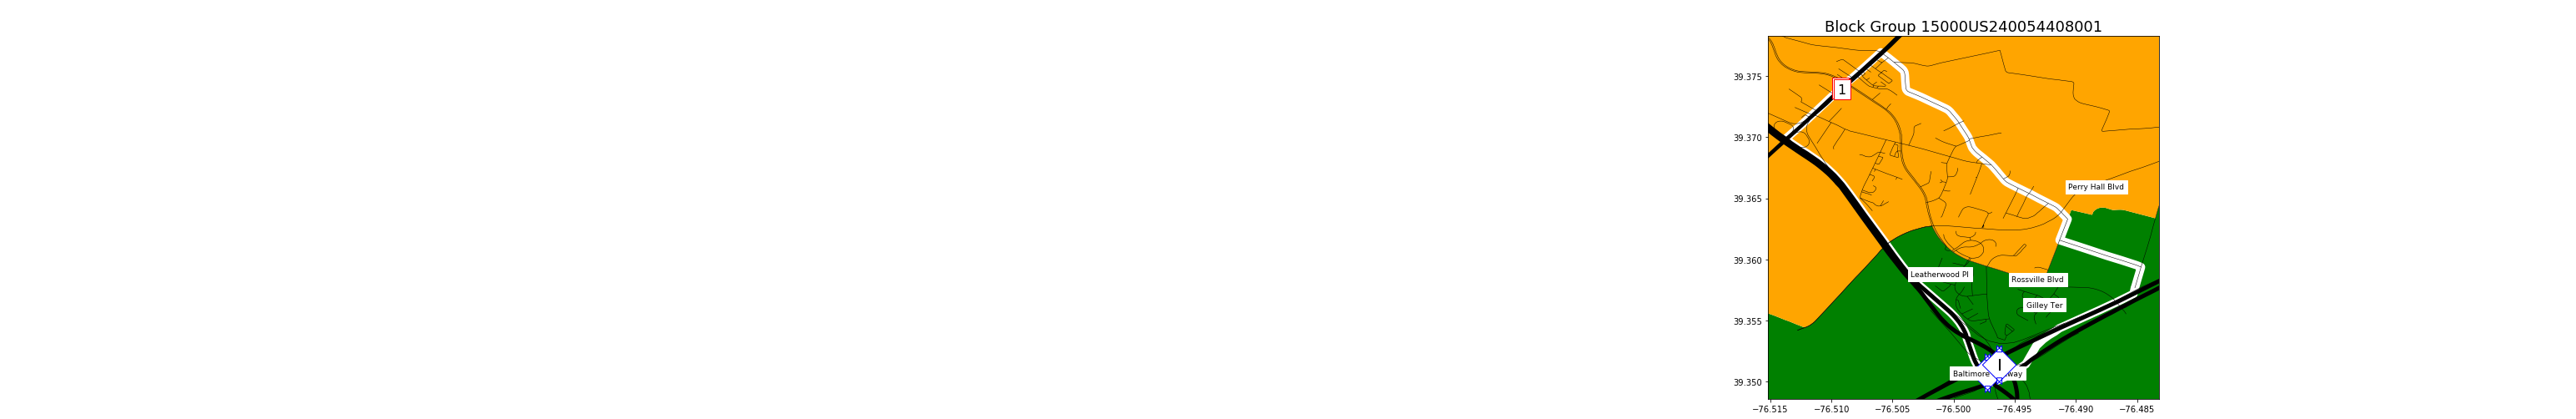

Done in 0 minutes 4 seconds!


In [20]:
s = time.time()
label_small_roads = True
label_small_road_types = ['Blvd'] 
basesize = 8
aspect_ratio = xspan / yspan

i = 2
this_block_group_id = explore_more[i]

suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0 }
other_roads = []

print('Examining block group {0:}'.format(this_block_group_id))
print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

block_group_geo = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.values[0]
total_block_group_area = block_group_geo.area
print('Total area {0:,.1f} km^2...'.format(total_block_group_area / 1000000))
print('\n')

# print('Finding roads in this block group...')
# road_linearids_in_this_block_group_list = []
# cnt = 0
# for ix, thisrow in roads_gdf.to_crs(equal_area_crs).iterrows():
#     if ((np.mod(cnt, 50000) == 0) | (cnt == len(roads_gdf) - 1)):
#         print('\tExamining road {0:,.0f} of {1:,.0f} in entire state...'.format(cnt+1, len(roads_gdf)))
#     if (thisrow.geometry.intersects(block_group_geo)):
#         road_linearids_in_this_block_group_list.append(ix)
#     cnt = cnt + 1

print('Found {0:,.0f} roads in block group {1:}'.format(len(road_linearids_in_this_block_group_list), this_block_group_id))
print('\n')

for i in range(1, len(test_this_bitmask)):
    if (test_this_bitmask[i] == '1'):
        print('Matching BG {0:} with district {1:.0f}...'.format(this_block_group_id, i))
        this_district_overlap_geo = cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].to_crs(equal_area_crs).geometry.apply(lambda x: x.intersection(block_group_geo)).values[0]
        this_district_overlap_area = this_district_overlap_geo.area
        print('\tDistrict {0:} overlaps {1:.1%} of the area...'.format(i, this_district_overlap_area / total_block_group_area))        
        match_road_network_length = 0
        for jx, thatrow in roads_gdf[
            (roads_gdf.index.isin(road_linearids_in_this_block_group_list))
        ].to_crs(equal_area_crs).iterrows():
            if (thatrow.geometry.intersects(this_district_overlap_geo)):
                match_road_network_length += thatrow.geometry.intersection(this_district_overlap_geo).length
        road_network_density = ((match_road_network_length)**2) / this_district_overlap_area
        print('\tDistrict {0:} overlap has {1:,.1f} km roads (density {2:,.1f})...'.format(i, match_road_network_length/1000, road_network_density))
        print('\n')

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))


print('Plotting official districts...')

legend_list = []
for i in range(1, len(test_this_bitmask)):
    if (test_this_bitmask[i] == '1'):
        cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
        legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
            
print('plotting tracts that overlap multiple districts...')
assembler_gdf[
    assembler_gdf.index == this_block_group_id
].plot(ax=ax, color='none', edgecolor='white', linewidth=10)

bounding_box = unary_union(
    assembler_gdf[
        assembler_gdf.index == this_block_group_id
    ].geometry.tolist()
).bounds
xlimits = (bounding_box[0], bounding_box[2])
ylimits = (bounding_box[1], bounding_box[3])

xspan = xlimits[1] - xlimits[0]
yspan = ylimits[1] - ylimits[0]

xbuffer = xspan * buffer_percent
ybuffer = yspan * buffer_percent

ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
#ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
    

# print('plotting water...')
# water_gdf.plot(ax=ax, color='blue')

print('plotting roads...')
roads_gdf[
    (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (~roads_gdf['RTTYP'].isin(['I','U','S','C']))
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
].plot(ax=ax, color='black', linewidth=0.5) 
roads_gdf[
    (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'C')
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
].plot(ax=ax, color='black', linewidth=1)
roads_gdf[
    (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'U')
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
].plot(ax=ax, color='black', linewidth=3)
roads_gdf[
    (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'I')
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
].plot(ax=ax, color='black', linewidth=5)

print('labeling roads...')
unique_names = []
for ix, thisrow in roads_gdf[roads_gdf.index.isin(road_linearids_in_this_block_group_list)].iterrows():
    has_custom_bbox = False
    thefontdict = {}
    labelsize = 9
    annotator = ''
    if (thisrow['RTTYP'] == 'I'):
        labelsize = 20
        annotator = thisrow['RTTYP']
        has_custom_bbox = True
        thebbox=dict(boxstyle="darrow", fc='white', ec='blue')
    elif (thisrow['RTTYP'] == 'U'):
        labelsize = 16
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
        has_custom_bbox = True
        thebbox=dict(boxstyle="square", fc='white', ec='red')
    elif (thisrow['RTTYP'] == 'S'):
        if ('42-679' in thisrow['FULLNAME']):
            labelsize = 14
            annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
            has_custom_bbox = True
            thebbox=dict(boxstyle="round,pad=0.5,rounding_size=1", fc='white', ec='orange')
    elif (thisrow['RTTYP'] == 'C'):
        labelsize = 10
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
        has_custom_bbox = True
        thebbox=dict(boxstyle="sawtooth,pad=1", fc='white')
    elif (label_small_roads):
        labelsize = 9
        if (thisrow['FULLNAME'] not in unique_names):
            unique_names.append(thisrow['FULLNAME'])
            if (re.search("\s",str(thisrow['FULLNAME'])) != None):
                road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1]
                is_other_road_type = True
                for k, v in suffixes_to_count_dict.items():
                    if (road_suffix == k):
                        suffixes_to_count_dict[k] = suffixes_to_count_dict[k] + 1
                        is_other_road_type = False
                if (is_other_road_type):
                    other_roads.append(thisrow['FULLNAME'])
                if ((road_suffix in label_small_road_types) | (is_other_road_type)):
                    annotator = thisrow['FULLNAME']
    if (has_custom_bbox):
        plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                     color='black', backgroundcolor='white', fontsize=labelsize, ha='center', va='center',
                     bbox = thebbox)
    else:
        plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                     color='black', backgroundcolor='white', fontsize=labelsize, ha='center', va='center')

plt.title("Block Group {0:}".format(this_block_group_id), fontsize=18)

if (label_small_roads):
    print("\tAnalysis of road names:")
    for k,v in suffixes_to_count_dict.items():
        print('\t\t{0:}: {1:,.0f}'.format(k,v))
    print('\tOther road names:')
    for x in other_roads:
        print('\t\t',x)
    print('\n')

# print('plotting places...')
# place_gdf[place_gdf.geometry.apply(lambda x: x.intersects(assembler_gdf.loc[this_block_group_id].geometry))].plot(ax=ax, color='purple', edgecolor='none')
    
    
print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))
print('\n')
plt.show()



e = time.time()
g = g + (e-s)
print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))




In [ ]:
for ix, thisrow in place_gdf.iterrows():
    if thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry):
        print(thisrow['NAME'])
        print('\n')

### Read water areas, places, roads

In [ ]:
s = time.time()

this_state = 'SC'
this_state_number = 45
#this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

if (debug >= 1):
    print('reading water shapefiles in {0:}...'.format(this_state))

water_gdf = geopandas.GeoDataFrame()
water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

for i in range(0, len(water_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
    water_gdf_i = geopandas.read_file(water_file_list[i])
    #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
    water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

water_gdf = water_gdf.set_index('HYDROID')
e = time.time()
g = g + (e-s)

if (debug >= 1):
    #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
    print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
#print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
s = time.time()

if (debug >= 1):
    print('reading place shapefiles in {0:}...'.format(this_state))

place_gdf = geopandas.GeoDataFrame()
place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

for i in range(0, len(place_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
    place_gdf_i = geopandas.read_file(place_file_list[i])
    
    place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

place_gdf = place_gdf.set_index('GEOID')
e = time.time()
g = g + (e-s)

if (debug >= 1):
    #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
    print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
#place_gdf.head(1)

s = time.time()

if (debug >= 1):
    print('reading roads shapefiles in {0:}...'.format(this_state))

roads_gdf = geopandas.GeoDataFrame()
roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

for i in range(0, len(roads_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
    roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
    roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

roads_gdf = roads_gdf.set_index('LINEARID')
e = time.time()
g = g + (e-s)

if (debug >= 1):
    #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
    print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

#roads_gdf.head(1).T
# Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy
